Reproducibility

In [ ]:
# ===============================================================
#  Aspect-Based Sentiment Analysis (ABSA) on DANA Security Aspect
#  Comparative Evaluation of SVM, Random Forest, CNN, BiLSTM, and IndoBERT
#  Author  : Aisyah Fatihaturrahmah
#  Affiliation : Faculty of Computer Science, Universitas Sriwijaya
#  Description : Final revised version
# ===============================================================

# === Reproducibility & Environment Configuration ===
# This section ensures all experiments can be reproduced deterministically.

#Python version    : 3.12.12
#Scikit-learn      : 1.6.1
#Transformers      : 4.57.1
#TensorFlow        : 2.19.0
#PyTorch           : 2.8.0+cu126
#Imbalanced-learn  : 0.14.0
#Numpy             : 2.0.2
#Pandas            : (runtime dependent)
# Random seed      : 42
# Environment      : Google Colab (Linux, CUDA-enabled GPU)
# ===============================================================

import os
import random
import numpy as np
import torch

# === Set Global Random Seed ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Optional: enforce deterministic computation in CUDA backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === Environment Check (optional, for appendix) ===
try:
    import sys, sklearn, transformers, tensorflow, imblearn
    print("=== Environment Versions (ABSA Experiment) ===")
    print(f"Python version    : {sys.version.split()[0]}")
    print(f"Scikit-learn      : {sklearn.__version__}")
    print(f"Transformers      : {transformers.__version__}")
    print(f"TensorFlow        : {tensorflow.__version__}")
    print(f"PyTorch           : {torch.__version__}")
    print(f"Imbalanced-learn  : {imblearn.__version__}")
    print(f"Numpy             : {np.__version__}")
    print(f"Pandas            : (runtime dependent)")
    print("=============================================\n")
except Exception as e:
    print(f"Environment check skipped: {e}")


=== Environment Versions (ABSA Experiment) ===
Python version    : 3.12.12
Scikit-learn      : 1.6.1
Transformers      : 4.57.1
TensorFlow        : 2.19.0
PyTorch           : 2.8.0+cu126
Imbalanced-learn  : 0.14.0
Numpy             : 2.0.2
Pandas            : (runtime dependent)



SVM

In [ ]:
!pip install imbalanced-learn --quiet
!pip install scipy scikit-learn matplotlib seaborn --quiet

In [ ]:
# ===============================================================
# MODEL 1 — SVM (TF-IDF + Oversampling In-Fold)
# Dataset: Combined (Old + New)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, auc, classification_report
)
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from scipy import stats
import joblib
import os

In [ ]:
# ------------------------------
# SETUP
# ------------------------------
RSEED = 42
os.makedirs("plots", exist_ok=True)
os.makedirs("metrics", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [ ]:
# ------------------------------
# LOAD DATA
# ------------------------------
df = pd.read_csv("combined_dataset_labeled_binary.csv")

# Validasi kolom
assert 'clean_content' in df.columns, "Kolom 'clean_content' tidak ditemukan!"
assert 'sentiment' in df.columns, "Kolom 'sentiment' tidak ditemukan!"

# Bersihkan
df['clean_content'] = df['clean_content'].astype(str).fillna('')
df = df[df['clean_content'].str.strip() != ''].reset_index(drop=True)

# Label numerik
label_map = {'negatif':0, 'positif':1, 'negative':0, 'positive':1, 0:0, 1:1}
df['sentiment'] = df['sentiment'].map(label_map)

X = df['clean_content'].values
y = df['sentiment'].values

print(f"✅ Total data valid: {len(df)}")
print("Distribusi kelas:\n", pd.Series(y).value_counts())

✅ Total data valid: 7846
Distribusi kelas:
 0    5477
1    2369
Name: count, dtype: int64


In [ ]:
# ------------------------------
# STRATIFIED K-FOLD
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
metrics_list = []
pr_curves = []
fold = 1

# Untuk confusion matrix
all_true, all_pred = [], []

In [ ]:
# loop - fold
for train_idx, test_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Pipeline: TF-IDF + Oversampling + SVM
    pipeline = ImbPipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('oversample', RandomOverSampler(random_state=RSEED)),
        ('clf', SVC(kernel='linear', probability=True, random_state=RSEED))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Simpan hasil prediksi gabungan
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    metrics_list.append({
        "fold": fold, "accuracy": acc, "f1_macro": f1, "roc_auc": roc, "pr_auc": pr_auc
    })
    pr_curves.append((recall, precision, f"Fold {fold}"))

    print(f"Accuracy={acc:.4f} | F1-macro={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr_auc:.4f}")
    fold += 1


📂 Fold 1
Accuracy=0.9210 | F1-macro=0.9050 | ROC-AUC=0.9642 | PR-AUC=0.9390

📂 Fold 2
Accuracy=0.9120 | F1-macro=0.8933 | ROC-AUC=0.9651 | PR-AUC=0.9435

📂 Fold 3
Accuracy=0.9089 | F1-macro=0.8896 | ROC-AUC=0.9546 | PR-AUC=0.9276

📂 Fold 4
Accuracy=0.9222 | F1-macro=0.9075 | ROC-AUC=0.9718 | PR-AUC=0.9493

📂 Fold 5
Accuracy=0.9197 | F1-macro=0.9030 | ROC-AUC=0.9628 | PR-AUC=0.9394


In [ ]:
# ------------------------------
# RECAP HASIL 5-FOLD
# ------------------------------
dfm = pd.DataFrame(metrics_list)
dfm.to_csv("metrics/svm_metrics.csv", index=False)
mean_acc, std_acc = np.mean(dfm['accuracy']), np.std(dfm['accuracy'])
mean_f1, std_f1 = np.mean(dfm['f1_macro']), np.std(dfm['f1_macro'])
mean_auc, std_auc = np.mean(dfm['roc_auc']), np.std(dfm['roc_auc'])
ci_f1 = stats.t.interval(0.95, len(dfm)-1, loc=mean_f1, scale=stats.sem(dfm['f1_macro']))

print("\n=== 📊 Ringkasan 5-Fold SVM ===")
print(f"Accuracy : {mean_acc:.3f} ± {std_acc:.3f}")
print(f"F1-macro : {mean_f1:.3f} ± {std_f1:.3f}, 95% CI = [{ci_f1[0]:.3f}, {ci_f1[1]:.3f}]")
print(f"ROC-AUC  : {mean_auc:.3f} ± {std_auc:.3f}")


=== 📊 Ringkasan 5-Fold SVM ===
Accuracy : 0.917 ± 0.005
F1-macro : 0.900 ± 0.007, 95% CI = [0.890, 0.909]
ROC-AUC  : 0.964 ± 0.005


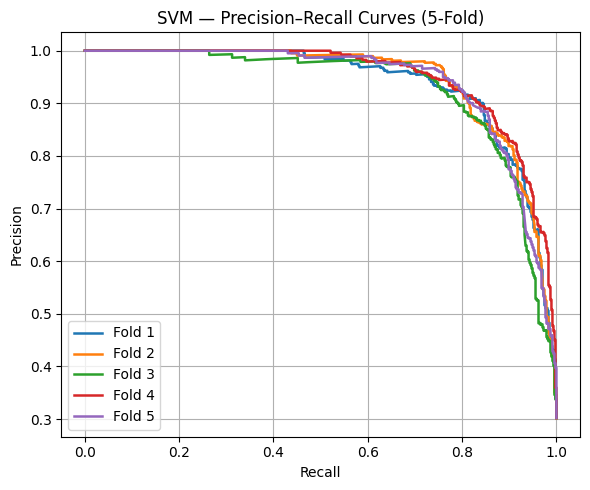

In [ ]:
# ------------------------------
# PRECISION–RECALL CURVES (per fold)
# ------------------------------
plt.figure(figsize=(6,5))
for recall, precision, label in pr_curves:
    plt.plot(recall, precision, lw=1.8, label=label)
plt.title("SVM — Precision–Recall Curves (5-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/svm_prcurve_folds.png", dpi=200)
plt.show()

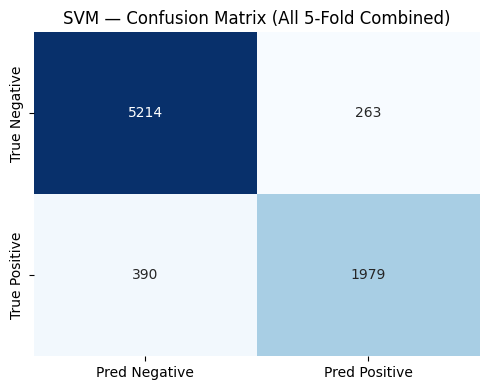

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred Negative","Pred Positive"],
            yticklabels=["True Negative","True Positive"])
plt.title("SVM — Confusion Matrix (All 5-Fold Combined)")
plt.tight_layout()
plt.savefig("plots/svm_confmatrix_combined.png", dpi=200)
plt.show()


In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================
final_pipeline = ImbPipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('oversample', RandomOverSampler(random_state=RSEED)),
    ('clf', SVC(kernel='linear', probability=True, random_state=RSEED))
])
final_pipeline.fit(X, y)
joblib.dump(final_pipeline, "saved_models/svm_pipeline_full.joblib")

print("✅ Final trained SVM model saved to saved_models/svm_pipeline_full.joblib")

✅ Final trained SVM model saved to saved_models/svm_pipeline_full.joblib


Random Forest


In [ ]:
# ===============================================================
# MODEL 2 — Random Forest (TF-IDF + Oversampling In-Fold)
# Dataset: Combined (Old + New)
# Confusion Matrix & PR-Curve ditampilkan di akhir
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, auc, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from scipy import stats
import joblib
import os

In [ ]:
# ------------------------------
# SETUP
# ------------------------------
RSEED = 42
os.makedirs("plots", exist_ok=True)
os.makedirs("metrics", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [ ]:
# ------------------------------
# LOAD DATA
# ------------------------------
df = pd.read_csv("combined_dataset_labeled_binary.csv")

# Validasi kolom
assert 'clean_content' in df.columns, "Kolom 'clean_content' tidak ditemukan!"
assert 'sentiment' in df.columns, "Kolom 'sentiment' tidak ditemukan!"

# Bersihkan
df['clean_content'] = df['clean_content'].astype(str).fillna('')
df = df[df['clean_content'].str.strip() != ''].reset_index(drop=True)

# Label numerik
label_map = {'negatif':0, 'positif':1, 'negative':0, 'positive':1, 0:0, 1:1}
df['sentiment'] = df['sentiment'].map(label_map)

X = df['clean_content'].values
y = df['sentiment'].values

print(f"✅ Total data valid: {len(df)}")
print("Distribusi kelas:\n", pd.Series(y).value_counts())

✅ Total data valid: 7846
Distribusi kelas:
 0    5477
1    2369
Name: count, dtype: int64


In [ ]:
# ------------------------------
# STRATIFIED K-FOLD
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
metrics_list = []
pr_curves = []
fold = 1
all_true, all_pred = [], []

In [ ]:
# ------------------------------
# TRAINING PER FOLD
# ------------------------------
for train_idx, test_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Pipeline: TF-IDF + Oversampling + Random Forest
    pipeline = ImbPipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('oversample', RandomOverSampler(random_state=RSEED)),
        ('clf', RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=RSEED,
            n_jobs=-1
        ))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Simpan prediksi gabungan
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    metrics_list.append({
        "fold": fold, "accuracy": acc, "f1_macro": f1, "roc_auc": roc, "pr_auc": pr_auc
    })
    pr_curves.append((recall, precision, f"Fold {fold}"))

    print(f"Accuracy={acc:.4f} | F1-macro={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr_auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

    fold += 1


📂 Fold 1
Accuracy=0.9312 | F1-macro=0.9150 | ROC-AUC=0.9701 | PR-AUC=0.9531
              precision    recall  f1-score   support

    Negative       0.93      0.98      0.95      1096
    Positive       0.95      0.82      0.88       474

    accuracy                           0.93      1570
   macro avg       0.94      0.90      0.91      1570
weighted avg       0.93      0.93      0.93      1570


📂 Fold 2
Accuracy=0.9344 | F1-macro=0.9179 | ROC-AUC=0.9702 | PR-AUC=0.9535
              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      1096
    Positive       0.97      0.81      0.88       473

    accuracy                           0.93      1569
   macro avg       0.95      0.90      0.92      1569
weighted avg       0.94      0.93      0.93      1569


📂 Fold 3
Accuracy=0.9210 | F1-macro=0.9000 | ROC-AUC=0.9555 | PR-AUC=0.9356
              precision    recall  f1-score   support

    Negative       0.91      0.99      0.95      1095
    Po

In [ ]:
# ------------------------------
# RINGKASAN 5-FOLD
# ------------------------------
dfm = pd.DataFrame(metrics_list)
dfm.to_csv("metrics/rf_metrics.csv", index=False)
mean_acc, std_acc = np.mean(dfm['accuracy']), np.std(dfm['accuracy'])
mean_f1, std_f1 = np.mean(dfm['f1_macro']), np.std(dfm['f1_macro'])
mean_auc, std_auc = np.mean(dfm['roc_auc']), np.std(dfm['roc_auc'])
ci_f1 = stats.t.interval(0.95, len(dfm)-1, loc=mean_f1, scale=stats.sem(dfm['f1_macro']))

print("\n=== 📊 Ringkasan 5-Fold Random Forest ===")
print(f"Accuracy : {mean_acc:.3f} ± {std_acc:.3f}")
print(f"F1-macro : {mean_f1:.3f} ± {std_f1:.3f}, 95% CI = [{ci_f1[0]:.3f}, {ci_f1[1]:.3f}]")
print(f"ROC-AUC  : {mean_auc:.3f} ± {std_auc:.3f}")


=== 📊 Ringkasan 5-Fold Random Forest ===
Accuracy : 0.928 ± 0.005
F1-macro : 0.910 ± 0.006, 95% CI = [0.901, 0.919]
ROC-AUC  : 0.967 ± 0.006


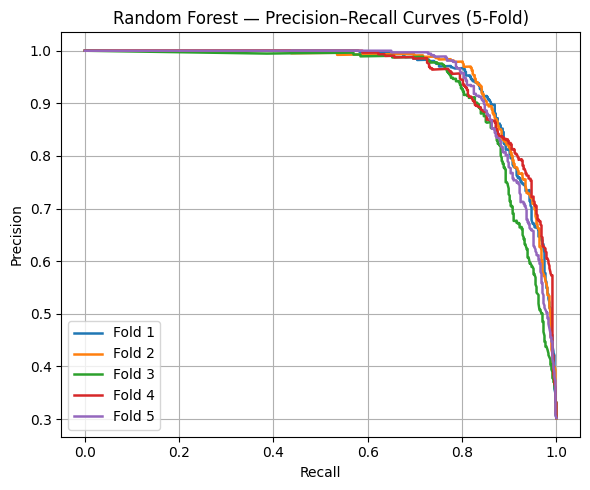

In [ ]:
# Precision–Recall Curve (gabungan semua fold)
plt.figure(figsize=(6,5))
for recall, precision, label in pr_curves:
    plt.plot(recall, precision, lw=1.8, label=label)
plt.title("Random Forest — Precision–Recall Curves (5-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/rf_prcurve_folds.png", dpi=200)
plt.show()

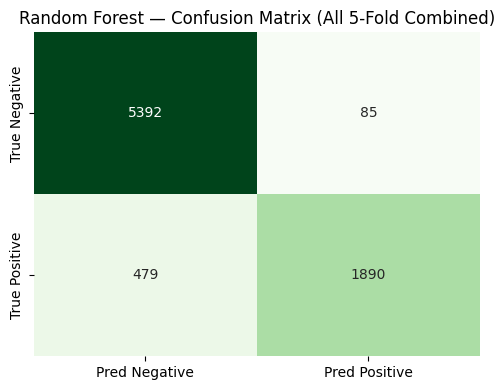

In [ ]:
# Confusion Matrix (gabungan seluruh prediksi dari 5 fold)
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Pred Negative","Pred Positive"],
            yticklabels=["True Negative","True Positive"])
plt.title("Random Forest — Confusion Matrix (All 5-Fold Combined)")
plt.tight_layout()
plt.savefig("plots/rf_confmatrix_combined.png", dpi=200)
plt.show()

In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================
final_pipeline = ImbPipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('oversample', RandomOverSampler(random_state=RSEED)),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=RSEED,
        n_jobs=-1
    ))
])
final_pipeline.fit(X, y)
joblib.dump(final_pipeline, "saved_models/rf_pipeline_full.joblib")

print("✅ Final trained RF model saved to saved_models/rf_pipeline_full.joblib")

✅ Final trained RF model saved to saved_models/rf_pipeline_full.joblib


CNN

In [ ]:
# ===============================================================
# MODEL 3 — CNN (Keras, dengan class_weight)
# Dataset: Combined (Old + New)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, callbacks
from scipy import stats
import tensorflow as tf
import os

In [ ]:
# ------------------------------
# SETUP
# ------------------------------
RSEED = 42
os.makedirs("plots", exist_ok=True)
os.makedirs("metrics", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)
np.random.seed(RSEED)
tf.random.set_seed(RSEED)

In [ ]:
# ------------------------------
# LOAD DATA
# ------------------------------
df = pd.read_csv("combined_dataset_labeled_binary.csv")

# Validasi kolom
assert 'clean_content' in df.columns, "Kolom 'clean_content' tidak ditemukan!"
assert 'sentiment' in df.columns, "Kolom 'sentiment' tidak ditemukan!"

# Bersihkan
df['clean_content'] = df['clean_content'].astype(str).fillna('')
df = df[df['clean_content'].str.strip() != ''].reset_index(drop=True)

# Label numerik
label_map = {'negatif':0, 'positif':1, 'negative':0, 'positive':1, 0:0, 1:1}
df['sentiment'] = df['sentiment'].map(label_map)

X = df['clean_content'].values
y = df['sentiment'].values

print(f"✅ Total data valid: {len(df)}")
print("Distribusi kelas:\n", pd.Series(y).value_counts())

✅ Total data valid: 7846
Distribusi kelas:
 0    5477
1    2369
Name: count, dtype: int64


In [ ]:
# ===============================================================
# ENCODING TEKS (Tokenizer + Padding)
# ===============================================================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

In [ ]:
# ===============================================================
# STRATIFIED K-FOLD
# ===============================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

metrics_list = []
pr_curves = []
all_true, all_pred = [], []
fold = 1

In [ ]:
# ===============================================================
# TRAINING PER FOLD
# ===============================================================
for train_idx, test_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    X_train_text, X_test_text = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Tokenisasi + Padding
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

    # class_weight untuk menangani imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Arsitektur CNN sederhana
    model = models.Sequential([
        layers.Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LEN),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    # Callback untuk early stopping
    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=10,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[es],
        verbose=1
    )

    # Prediksi probabilitas & label
    y_prob = model.predict(X_test_pad).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # Simpan prediksi
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    # Evaluasi per fold
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    metrics_list.append({
        "fold": fold, "accuracy": acc, "f1_macro": f1, "roc_auc": roc, "pr_auc": pr_auc
    })
    pr_curves.append((recall, precision, f"Fold {fold}"))

    print(f"Accuracy={acc:.4f} | F1-macro={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr_auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

    fold += 1


📂 Fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7248 - loss: 0.5198 - val_accuracy: 0.9134 - val_loss: 0.2382
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9380 - loss: 0.1763 - val_accuracy: 0.9389 - val_loss: 0.1602
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9741 - loss: 0.0819 - val_accuracy: 0.9459 - val_loss: 0.1555
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9913 - loss: 0.0319 - val_accuracy: 0.9376 - val_loss: 0.1823
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9965 - loss: 0.0152 - val_accuracy: 0.9287 - val_loss: 0.2291
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9172 - val_loss: 0.2678
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy=0.9459 | F1-macro=0.9361 | ROC-AUC=0.9823 | PR-AUC=0.9696
              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96      1096
    Positive       0.90     

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6970 - loss: 0.5185 - val_accuracy: 0.9216 - val_loss: 0.2059
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9385 - loss: 0.1749 - val_accuracy: 0.9509 - val_loss: 0.1429
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0797 - val_accuracy: 0.9516 - val_loss: 0.1450
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9899 - loss: 0.0324 - val_accuracy: 0.9458 - val_loss: 0.1646
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0136 - val_accuracy: 0.9452 - val_loss: 0.1917
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy=0.9509 | F1-macro=0.9417 | ROC-AUC=0.9823 | PR-AUC=0.9717
              precision    recall  f1-score   support

    Negative       0.96      0.97      0.96      1096
    Positive       0.92      0.92      0.92       473

    accuracy                           0.95      1569
   macro avg       0.94      0.94      0.94      1569
we

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7870 - loss: 0.5188 - val_accuracy: 0.8936 - val_loss: 0.2516
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9404 - loss: 0.1710 - val_accuracy: 0.9248 - val_loss: 0.1926
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9799 - loss: 0.0687 - val_accuracy: 0.9242 - val_loss: 0.2089
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9934 - loss: 0.0246 - val_accuracy: 0.9305 - val_loss: 0.2249
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9968 - loss: 0.0105 - val_accuracy: 0.9299 - val_loss: 0.2483
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy=0.9248 | F1-macro=0.9130 | ROC-AUC=0.9777 | PR-AUC=0.9604
              precision    recall  f1-score   support

    Negative       0.96      0.93      0.95      1095
    Positive       0.84      0.92      0.88       474

    accuracy                           0.92      1569
   macro avg       0.90      0.92      0.91      1569
we

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7893 - loss: 0.5199 - val_accuracy: 0.9312 - val_loss: 0.2003
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9337 - loss: 0.1833 - val_accuracy: 0.9382 - val_loss: 0.1638
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9676 - loss: 0.0876 - val_accuracy: 0.9471 - val_loss: 0.1569
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9914 - loss: 0.0304 - val_accuracy: 0.9516 - val_loss: 0.1770
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9958 - loss: 0.0142 - val_accuracy: 0.9509 - val_loss: 0.1956
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0062 - val_accuracy: 0.9503 - val_loss: 0.2154
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy=0.9471 | F1-macro=0.9378 | ROC-AUC=0.9818 | PR-AUC=0.9713
              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96      1095
    Positive       0.90      0.93      

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7638 - loss: 0.5158 - val_accuracy: 0.8859 - val_loss: 0.2413
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9331 - loss: 0.1882 - val_accuracy: 0.9267 - val_loss: 0.1756
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9681 - loss: 0.0874 - val_accuracy: 0.9363 - val_loss: 0.1626
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9891 - loss: 0.0338 - val_accuracy: 0.9363 - val_loss: 0.1824
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0129 - val_accuracy: 0.9388 - val_loss: 0.2335
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0079 - val_accuracy: 0.9337 - val_loss: 0.2386
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy=0.9363 | F1-macro=0.9244 | ROC-AUC=0.9819 | PR-AUC=0.9684
              precision    recall  f1-score   support

    Negative       0.95      0.95      0.95      1095
    Positive       0.89      0.89      

In [ ]:
# ===============================================================
# RINGKASAN HASIL 5-FOLD
# ===============================================================
dfm = pd.DataFrame(metrics_list)
dfm.to_csv("metrics/cnn_metrics.csv", index=False)

mean_acc, std_acc = np.mean(dfm['accuracy']), np.std(dfm['accuracy'])
mean_f1, std_f1 = np.mean(dfm['f1_macro']), np.std(dfm['f1_macro'])
mean_auc, std_auc = np.mean(dfm['roc_auc']), np.std(dfm['roc_auc'])
ci_f1 = stats.t.interval(0.95, len(dfm)-1, loc=mean_f1, scale=stats.sem(dfm['f1_macro']))

print("\n=== 📊 Ringkasan 5-Fold CNN ===")
print(f"Accuracy : {mean_acc:.3f} ± {std_acc:.3f}")
print(f"F1-macro : {mean_f1:.3f} ± {std_f1:.3f}, 95% CI = [{ci_f1[0]:.3f}, {ci_f1[1]:.3f}]")
print(f"ROC-AUC  : {mean_auc:.3f} ± {std_auc:.3f}")


=== 📊 Ringkasan 5-Fold CNN ===
Accuracy : 0.941 ± 0.009
F1-macro : 0.931 ± 0.011, 95% CI = [0.916, 0.945]
ROC-AUC  : 0.981 ± 0.002


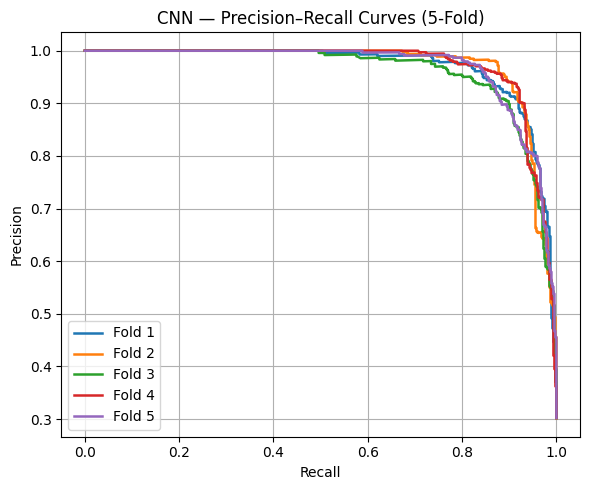

In [ ]:
# Precision–Recall Curve
plt.figure(figsize=(6,5))
for recall, precision, label in pr_curves:
    plt.plot(recall, precision, lw=1.8, label=label)
plt.title("CNN — Precision–Recall Curves (5-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/cnn_prcurve_folds.png", dpi=200)
plt.show()

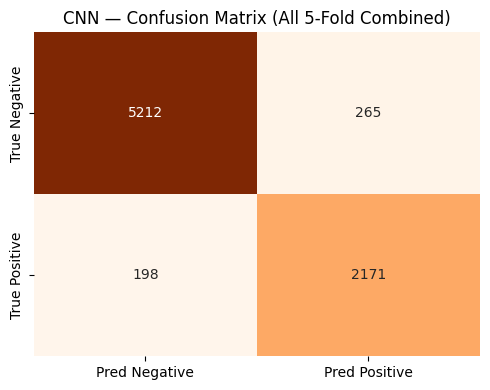

In [ ]:
# Confusion Matrix (gabungan semua fold)
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=["Pred Negative","Pred Positive"],
            yticklabels=["True Negative","True Positive"])
plt.title("CNN — Confusion Matrix (All 5-Fold Combined)")
plt.tight_layout()
plt.savefig("plots/cnn_confmatrix_combined.png", dpi=200)
plt.show()

In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================
X_seq_full = tokenizer.texts_to_sequences(X)
X_pad_full = pad_sequences(X_seq_full, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

# class_weight untuk full data
class_weights_full = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_full = dict(enumerate(class_weights_full))

final_model = models.Sequential([
    layers.Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LEN),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.fit(X_pad_full, y, epochs=10, batch_size=64, class_weight=class_weights_full, verbose=1)

final_model.save("saved_models/cnn_model_full.h5")
print("✅ Final trained CNN model saved to saved_models/cnn_model_full.h5")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7924 - loss: 0.5000
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9389 - loss: 0.1711
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9705 - loss: 0.0880
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9924 - loss: 0.0333
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9974 - loss: 0.0126
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0066
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0055
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0043
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.0041
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0037


✅ Final trained CNN model saved to saved_models/cnn_model_full.h5


BiLSTM

In [ ]:
# ===============================================================
# MODEL 4 — BiLSTM (Keras, dengan class_weight)
# Dataset: Combined (Old + New)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, callbacks
from scipy import stats
import tensorflow as tf
import os

In [ ]:
# ------------------------------
# SETUP
# ------------------------------
RSEED = 42
os.makedirs("plots", exist_ok=True)
os.makedirs("metrics", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)
np.random.seed(RSEED)
tf.random.set_seed(RSEED)

In [ ]:
# ------------------------------
# LOAD DATA
# ------------------------------
df = pd.read_csv("combined_dataset_labeled_binary.csv")

assert 'clean_content' in df.columns, "Kolom 'clean_content' tidak ditemukan!"
assert 'sentiment' in df.columns, "Kolom 'sentiment' tidak ditemukan!"

df['clean_content'] = df['clean_content'].astype(str).fillna('')
df = df[df['clean_content'].str.strip() != ''].reset_index(drop=True)

label_map = {'negatif':0, 'positif':1, 'negative':0, 'positive':1, 0:0, 1:1}
df['sentiment'] = df['sentiment'].map(label_map)

X = df['clean_content'].values
y = df['sentiment'].values

print(f"✅ Total data valid: {len(df)}")
print("Distribusi kelas:\n", pd.Series(y).value_counts())

✅ Total data valid: 7846
Distribusi kelas:
 0    5477
1    2369
Name: count, dtype: int64


In [ ]:
# ===============================================================
# TOKENIZER + PADDING
# ===============================================================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

In [ ]:
# ===============================================================
# STRATIFIED K-FOLD
# ===============================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

metrics_list = []
pr_curves = []
all_true, all_pred = [], []
fold = 1

In [ ]:
# ===============================================================
# TRAINING PER FOLD
# ===============================================================
for train_idx, test_idx in skf.split(X, y):
    print(f"\n📂 Fold {fold}")
    X_train_text, X_test_text = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Tokenisasi + Padding
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

    # class_weight untuk imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Arsitektur BiLSTM
    model = models.Sequential([
        layers.Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LEN),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Training
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=10,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[es],
        verbose=1
    )

    # Prediksi
    y_prob = model.predict(X_test_pad).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

    # Evaluasi
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    metrics_list.append({
        "fold": fold, "accuracy": acc, "f1_macro": f1, "roc_auc": roc, "pr_auc": pr_auc
    })
    pr_curves.append((recall, precision, f"Fold {fold}"))

    print(f"Accuracy={acc:.4f} | F1-macro={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr_auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

    fold += 1


📂 Fold 1
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6733 - loss: 0.5454 - val_accuracy: 0.8548 - val_loss: 0.3096
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8982 - loss: 0.2568 - val_accuracy: 0.9146 - val_loss: 0.2329
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9577 - loss: 0.1400 - val_accuracy: 0.9185 - val_loss: 0.2298
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9760 - loss: 0.0805 - val_accuracy: 0.9076 - val_loss: 0.3001
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9850 - loss: 0.0527 - val_accuracy: 0.8968 - val_loss: 0.3743
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9908 - loss: 0.0331 - val_accuracy: 0.8994 - val_loss: 0.4544
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy=0.9185 | F1-macro=0.9034 | ROC-AUC=0.9686 | PR-AUC=0.9441
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1096
    Positive       0.86      0.87 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6330 - loss: 0.5495 - val_accuracy: 0.8783 - val_loss: 0.2753
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9150 - loss: 0.2322 - val_accuracy: 0.9165 - val_loss: 0.2255
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9603 - loss: 0.1273 - val_accuracy: 0.9222 - val_loss: 0.2296
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9724 - loss: 0.0847 - val_accuracy: 0.9197 - val_loss: 0.2994
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9818 - loss: 0.0564 - val_accuracy: 0.9191 - val_loss: 0.3266
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy=0.9165 | F1-macro=0.9011 | ROC-AUC=0.9602 | PR-AUC=0.9406
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1096
    Positive       0.86      0.86      0.86       473

    accuracy                           0.92      1569
   macro avg       0.90      0.90      0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6982 - loss: 0.5511 - val_accuracy: 0.9076 - val_loss: 0.2822
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9093 - loss: 0.2297 - val_accuracy: 0.8693 - val_loss: 0.3215
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9568 - loss: 0.1310 - val_accuracy: 0.9108 - val_loss: 0.2545
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9725 - loss: 0.0836 - val_accuracy: 0.9120 - val_loss: 0.3176
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9819 - loss: 0.0584 - val_accuracy: 0.9108 - val_loss: 0.3272
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9881 - loss: 0.0362 - val_accuracy: 0.9050 - val_loss: 0.3745
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy=0.9108 | F1-macro=0.8954 | ROC-AUC=0.9559 | PR-AUC=0.9232
              precision    recall  f1-score   support

    Negative       0.94      0.93      0.94      1095
    Positive       0.84      0.87

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7270 - loss: 0.5380 - val_accuracy: 0.8713 - val_loss: 0.3037
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9089 - loss: 0.2373 - val_accuracy: 0.9184 - val_loss: 0.2187
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9536 - loss: 0.1420 - val_accuracy: 0.9089 - val_loss: 0.2837
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9737 - loss: 0.0923 - val_accuracy: 0.8878 - val_loss: 0.3623
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9797 - loss: 0.0652 - val_accuracy: 0.9235 - val_loss: 0.2687
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy=0.9184 | F1-macro=0.9039 | ROC-AUC=0.9678 | PR-AUC=0.9381
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94      1095
    Positive       0.86      0.88      0.87       474

    accuracy                           0.92      1569
   macro avg       0.90      0.91      0.90      15

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7623 - loss: 0.5481 - val_accuracy: 0.8815 - val_loss: 0.2795
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9107 - loss: 0.2383 - val_accuracy: 0.9165 - val_loss: 0.2288
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9566 - loss: 0.1309 - val_accuracy: 0.9108 - val_loss: 0.2487
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9739 - loss: 0.0759 - val_accuracy: 0.9184 - val_loss: 0.2704
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9822 - loss: 0.0493 - val_accuracy: 0.9038 - val_loss: 0.3298
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy=0.9165 | F1-macro=0.9013 | ROC-AUC=0.9592 | PR-AUC=0.9324
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1095
    Positive       0.86      0.87      0.86       474

    accuracy                           0.92      1569
   macro avg       0.90      0.90      0.90      156

In [ ]:
# ===============================================================
# RINGKASAN HASIL 5-FOLD
# ===============================================================
dfm = pd.DataFrame(metrics_list)
dfm.to_csv("metrics/bilstm_metrics.csv", index=False)

mean_acc, std_acc = np.mean(dfm['accuracy']), np.std(dfm['accuracy'])
mean_f1, std_f1 = np.mean(dfm['f1_macro']), np.std(dfm['f1_macro'])
mean_auc, std_auc = np.mean(dfm['roc_auc']), np.std(dfm['roc_auc'])
ci_f1 = stats.t.interval(0.95, len(dfm)-1, loc=mean_f1, scale=stats.sem(dfm['f1_macro']))

print("\n=== 📊 Ringkasan 5-Fold BiLSTM ===")
print(f"Accuracy : {mean_acc:.3f} ± {std_acc:.3f}")
print(f"F1-macro : {mean_f1:.3f} ± {std_f1:.3f}, 95% CI = [{ci_f1[0]:.3f}, {ci_f1[1]:.3f}]")
print(f"ROC-AUC  : {mean_auc:.3f} ± {std_auc:.3f}")


=== 📊 Ringkasan 5-Fold BiLSTM ===
Accuracy : 0.916 ± 0.003
F1-macro : 0.901 ± 0.003, 95% CI = [0.897, 0.905]
ROC-AUC  : 0.962 ± 0.005


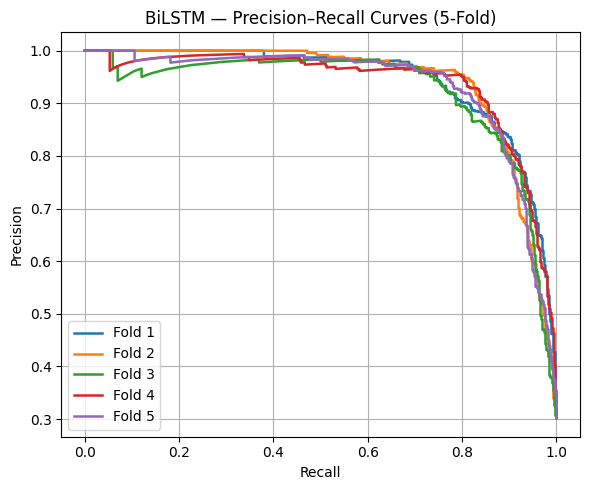

In [ ]:
# Precision–Recall Curve
plt.figure(figsize=(6,5))
for recall, precision, label in pr_curves:
    plt.plot(recall, precision, lw=1.8, label=label)
plt.title("BiLSTM — Precision–Recall Curves (5-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/bilstm_prcurve_folds.png", dpi=200)
plt.show()

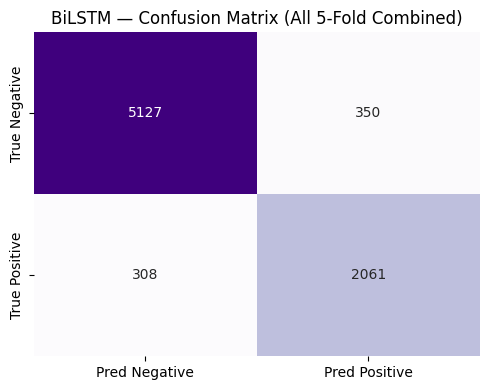

In [ ]:
# Confusion Matrix gabungan
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=["Pred Negative","Pred Positive"],
            yticklabels=["True Negative","True Positive"])
plt.title("BiLSTM — Confusion Matrix (All 5-Fold Combined)")
plt.tight_layout()
plt.savefig("plots/bilstm_confmatrix_combined.png", dpi=200)
plt.show()

In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================
X_seq_full = tokenizer.texts_to_sequences(X)
X_pad_full = pad_sequences(X_seq_full, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

class_weights_full = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_full = dict(enumerate(class_weights_full))

final_model = models.Sequential([
    layers.Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LEN),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.fit(X_pad_full, y, epochs=10, batch_size=64, class_weight=class_weights_full, verbose=1)

final_model.save("saved_models/bilstm_model_full.h5")
print("✅ Final trained BiLSTM model saved to saved_models/bilstm_model_full.h5")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7254 - loss: 0.5169
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9245 - loss: 0.2205
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9526 - loss: 0.1337
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9737 - loss: 0.0791
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9816 - loss: 0.0500
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9874 - loss: 0.0396
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9904 - loss: 0.0335
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9895 - loss: 0.0370
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9910 - loss: 0.0257
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9892 - loss: 0.0349


✅ Final trained BiLSTM model saved to saved_models/bilstm_model_full.h5


IndoBERT

In [ ]:
!pip install transformers datasets torch scikit-learn seaborn matplotlib tqdm --quiet

In [ ]:
# ===============================================================
# MODEL 5 — IndoBERT Fine-Tuning (Transformers)
# Dataset: Combined (Old + New)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, precision_recall_curve
)
from scipy import stats
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os

In [ ]:
# =============================
# SETUP
# =============================
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device in use: {device}")

# Seed agar hasil reproducible
RSEED = 42
np.random.seed(RSEED)
torch.manual_seed(RSEED)

✅ Device in use: cuda


In [ ]:
# =============================
# LOAD DATA
# =============================
df = pd.read_csv("/content/combined_dataset_labeled_binary.csv")

# Pastikan kolom dan ubah label ke numerik
assert 'clean_content' in df.columns and 'sentiment' in df.columns
df['clean_content'] = df['clean_content'].astype(str).fillna('')
df = df[df['clean_content'].str.strip() != ''].reset_index(drop=True)
label_map = {'negatif': 0, 'positif': 1, 'negative': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(label_map)

texts = df["clean_content"].tolist()
y = np.array(df["sentiment"])
classes = ["Negatif", "Positif"]

print(f"✅ Total data valid: {len(df)}")
print("Distribusi kelas:")
print(pd.Series(y).value_counts())

✅ Total data valid: 7846
Distribusi kelas:
0    5477
1    2369
Name: count, dtype: int64


In [ ]:
# =============================
# TOKENIZER INDO BERT
# =============================
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_texts(texts, tokenizer, max_len=128):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# =============================
# EVALUASI FUNGSI
# =============================
def evaluate(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred, average="macro")
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    return f1, roc_auc, pr_auc, y_pred

In [ ]:
# =============================
# STRATIFIED 5-FOLD CV
# =============================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
f1_scores, roc_scores, pr_auc_scores = [], [], []
all_true, all_pred, all_prob = [], [], []
pr_curves = []  # untuk menyimpan PR-Curve tiap fold

for fold, (train_idx, test_idx) in enumerate(kf.split(texts, y)):
    print(f"\n📂 Fold {fold+1}")

    # Split data per fold
    train_texts = [texts[i] for i in train_idx]
    test_texts = [texts[i] for i in test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Tokenisasi
    X_train_ids, X_train_mask = encode_texts(train_texts, tokenizer)
    X_test_ids, X_test_mask = encode_texts(test_texts, tokenizer)

    # Dataset dan DataLoader
    train_dataset = TensorDataset(X_train_ids, X_train_mask, torch.tensor(y_train))
    test_dataset = TensorDataset(X_test_ids, X_test_mask, torch.tensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Hitung class weight untuk training set (menghindari leakage)
    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    cw_tensor = torch.tensor(cw, dtype=torch.float).to(device)

    # Load model IndoBERT
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=cw_tensor[1].unsqueeze(0))

    # Training per fold
    model.train()
    for epoch in range(3):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}", leave=False, disable=True):
            b_ids, b_mask, b_labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(b_ids, attention_mask=b_mask)
            loss = loss_fn(outputs.logits.view(-1), b_labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"  🧠 Rata-rata loss epoch {epoch+1}: {total_loss/len(train_loader):.4f}")

    # Evaluasi per fold
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in test_loader:
            b_ids, b_mask, _ = [x.to(device) for x in batch]
            outputs = model(b_ids, attention_mask=b_mask)
            prob = torch.sigmoid(outputs.logits).cpu().numpy().ravel()
            probs.extend(prob)
    probs = np.array(probs)

    f1, roc_auc, pr_auc, y_pred = evaluate(y_test, probs)
    f1_scores.append(f1)
    roc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)

    all_true.extend(y_test)
    all_pred.extend(y_pred)
    all_prob.extend(probs)

    # Simpan PR curve per fold
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_curves.append((recall, precision, f"Fold {fold+1}"))

    print(f"Accuracy Fold {fold+1}: F1={f1:.3f} | ROC-AUC={roc_auc:.3f} | PR-AUC={pr_auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))


📂 Fold 1


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

  🧠 Rata-rata loss epoch 1: 0.2827
  🧠 Rata-rata loss epoch 2: 0.1311
  🧠 Rata-rata loss epoch 3: 0.0751
Accuracy Fold 1: F1=0.955 | ROC-AUC=0.987 | PR-AUC=0.976
              precision    recall  f1-score   support

     Negatif       0.97      0.97      0.97      1096
     Positif       0.93      0.94      0.94       474

    accuracy                           0.96      1570
   macro avg       0.95      0.96      0.95      1570
weighted avg       0.96      0.96      0.96      1570


📂 Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  🧠 Rata-rata loss epoch 1: 0.2947
  🧠 Rata-rata loss epoch 2: 0.1265
  🧠 Rata-rata loss epoch 3: 0.0725
Accuracy Fold 2: F1=0.956 | ROC-AUC=0.989 | PR-AUC=0.982
              precision    recall  f1-score   support

     Negatif       0.97      0.97      0.97      1096
     Positif       0.94      0.94      0.94       473

    accuracy                           0.96      1569
   macro avg       0.96      0.96      0.96      1569
weighted avg       0.96      0.96      0.96      1569


📂 Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  🧠 Rata-rata loss epoch 1: 0.2873
  🧠 Rata-rata loss epoch 2: 0.1334
  🧠 Rata-rata loss epoch 3: 0.0776
Accuracy Fold 3: F1=0.960 | ROC-AUC=0.984 | PR-AUC=0.978
              precision    recall  f1-score   support

     Negatif       0.97      0.98      0.98      1095
     Positif       0.96      0.93      0.94       474

    accuracy                           0.97      1569
   macro avg       0.96      0.96      0.96      1569
weighted avg       0.97      0.97      0.97      1569


📂 Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  🧠 Rata-rata loss epoch 1: 0.2956
  🧠 Rata-rata loss epoch 2: 0.1269
  🧠 Rata-rata loss epoch 3: 0.0784
Accuracy Fold 4: F1=0.957 | ROC-AUC=0.988 | PR-AUC=0.982
              precision    recall  f1-score   support

     Negatif       0.97      0.98      0.97      1095
     Positif       0.96      0.92      0.94       474

    accuracy                           0.96      1569
   macro avg       0.96      0.95      0.96      1569
weighted avg       0.96      0.96      0.96      1569


📂 Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  🧠 Rata-rata loss epoch 1: 0.2975
  🧠 Rata-rata loss epoch 2: 0.1338
  🧠 Rata-rata loss epoch 3: 0.0863
Accuracy Fold 5: F1=0.941 | ROC-AUC=0.985 | PR-AUC=0.975
              precision    recall  f1-score   support

     Negatif       0.97      0.96      0.96      1095
     Positif       0.90      0.93      0.92       474

    accuracy                           0.95      1569
   macro avg       0.94      0.94      0.94      1569
weighted avg       0.95      0.95      0.95      1569



In [ ]:
# =============================
# RINGKASAN 5-FOLD
# =============================
def summary_metric(values):
    n = len(values)
    mean = np.mean(values)
    sd = np.std(values, ddof=1)
    se = sd / np.sqrt(n)
    ci_low, ci_high = stats.t.interval(0.95, n-1, mean, se)
    return mean, sd, (ci_low, ci_high)

f1_mean, f1_sd, f1_ci = summary_metric(f1_scores)
roc_mean, roc_sd, roc_ci = summary_metric(roc_scores)
pr_mean, pr_sd, pr_ci = summary_metric(pr_auc_scores)

print("\n=== 📊 RINGKASAN 5-FOLD INDO BERT ===")
print(f"F1 (macro): {f1_mean:.3f} ± {f1_sd:.3f}, 95% CI: [{f1_ci[0]:.3f}, {f1_ci[1]:.3f}]")
print(f"ROC-AUC: {roc_mean:.3f} ± {roc_sd:.3f}, 95% CI: [{roc_ci[0]:.3f}, {roc_ci[1]:.3f}]")
print(f"PR-AUC: {pr_mean:.3f} ± {pr_sd:.3f}, 95% CI: [{pr_ci[0]:.3f}, {pr_ci[1]:.3f}]")


=== 📊 RINGKASAN 5-FOLD INDO BERT ===
F1 (macro): 0.954 ± 0.008, 95% CI: [0.944, 0.963]
ROC-AUC: 0.986 ± 0.002, 95% CI: [0.984, 0.989]
PR-AUC: 0.979 ± 0.003, 95% CI: [0.974, 0.983]


In [ ]:
# Simpan hasil tiap fold
os.makedirs("metrics", exist_ok=True)
fold_results = pd.DataFrame({
    "Fold": range(1, 6),
    "F1_macro": f1_scores,
    "ROC_AUC": roc_scores,
    "PR_AUC": pr_auc_scores
})
fold_results.to_csv("metrics/indobert_results.csv", index=False)
print("✅ Hasil tiap fold disimpan sebagai metrics/indobert_results.csv")

✅ Hasil tiap fold disimpan sebagai metrics/indobert_results.csv


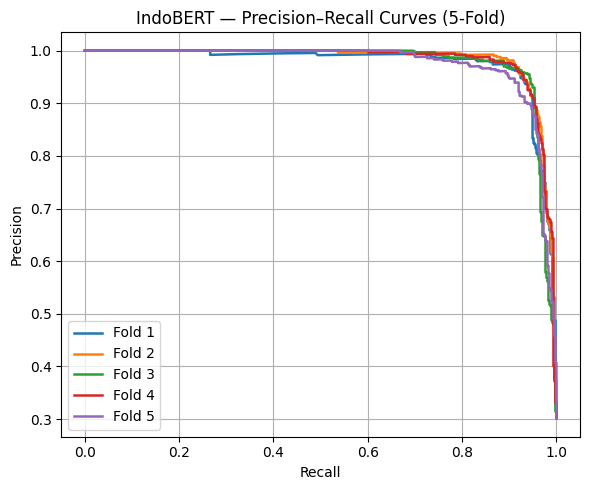

In [ ]:
#pr curve
plt.figure(figsize=(6,5))
for recall, precision, label in pr_curves:
    plt.plot(recall, precision, lw=1.8, label=label)
plt.title("IndoBERT — Precision–Recall Curves (5-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

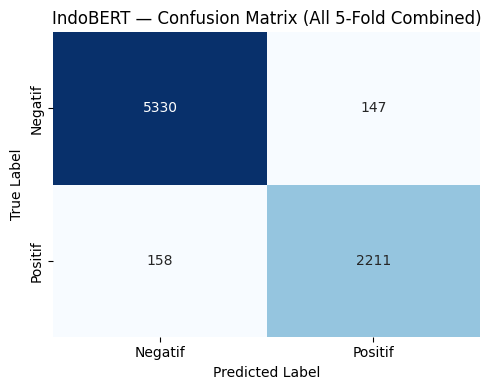

In [ ]:
# cnfussion matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title("IndoBERT — Confusion Matrix (All 5-Fold Combined)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================
print("\n🚀 Fine-tuning IndoBERT pada seluruh dataset...")


🚀 Fine-tuning IndoBERT pada seluruh dataset...


In [ ]:
# Tokenisasi seluruh data
X_ids, X_mask = encode_texts(texts, tokenizer)
dataset_full = TensorDataset(X_ids, X_mask, torch.tensor(y))
loader_full = DataLoader(dataset_full, batch_size=16, shuffle=True)

In [ ]:
# Hitung class weight untuk seluruh data
cw_full = compute_class_weight('balanced', classes=np.unique(y), y=y)
cw_full = dict(enumerate(cw_full))
class_weights_tensor = torch.tensor(list(cw_full.values()), dtype=torch.float).to(device)

In [ ]:
# Muat model IndoBERT baru untuk pelatihan penuh
final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
final_model.to(device)

optimizer = AdamW(final_model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1].unsqueeze(0))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Proses fine-tuning penuh
final_model.train()
EPOCHS = 3
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in tqdm(loader_full, desc=f"Full Data | Epoch {epoch+1}"):
        b_ids, b_mask, b_labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = final_model(b_ids, attention_mask=b_mask)
        loss = loss_fn(outputs.logits.view(-1), b_labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"  🧠 Rata-rata loss epoch {epoch+1}: {total_loss/len(loader_full):.4f}")

Full Data | Epoch 1: 100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


  🧠 Rata-rata loss epoch 1: 0.2630


Full Data | Epoch 2: 100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


  🧠 Rata-rata loss epoch 2: 0.1220


Full Data | Epoch 3: 100%|██████████| 491/491 [02:22<00:00,  3.44it/s]

  🧠 Rata-rata loss epoch 3: 0.0802


In [ ]:
# ===============================================================
# FINAL MODEL (TRAINED ON FULL DATA)
# ===============================================================

save_dir = "saved_models/indobert_model_full"
os.makedirs(save_dir, exist_ok=True)
final_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("✅ Final trained IndoBERT model saved to saved_models/indobert_model_full/")

✅ Final trained IndoBERT model saved to saved_models/indobert_model_full/


Visualisasi Gabungan

In [ ]:
import matplotlib.pyplot as plt

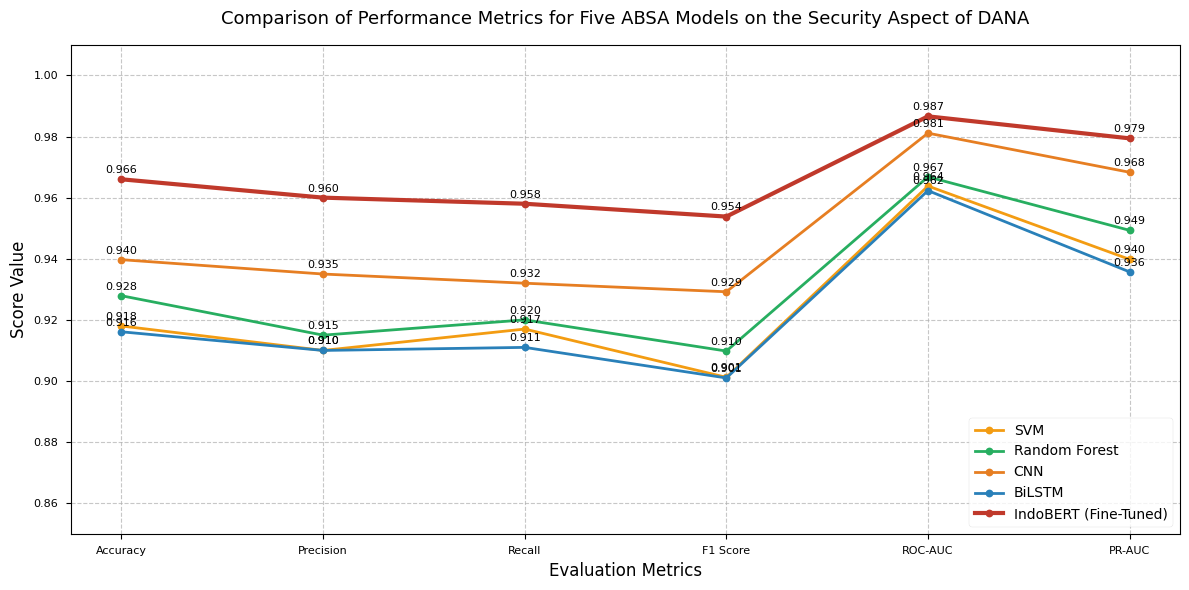

In [ ]:
# =============================
# METRIK & NILAI RATA-RATA 5-FOLD
# =============================
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'PR-AUC']

svm_scores      = [0.9180, 0.9100, 0.9170, 0.9012, 0.9638, 0.9398]
rf_scores       = [0.9279, 0.9150, 0.9200, 0.9098, 0.9668, 0.9493]
cnn_scores      = [0.9397, 0.9350, 0.9320, 0.9292, 0.9811, 0.9683]
bilstm_scores   = [0.9161, 0.9100, 0.9110, 0.9010, 0.9623, 0.9357]
indobert_scores = [0.9660, 0.9600, 0.9580, 0.9538, 0.9866, 0.9794]

# ===============================================================
# GAYA VISUALISASI
# ===============================================================
plt.style.use('seaborn-v0_8-paper')
plt.figure(figsize=(12, 6))

# Plot tiap model dengan warna konsisten
plt.plot(metrics, svm_scores, marker='o', color='#f39c12', linewidth=2, label='SVM')
plt.plot(metrics, rf_scores, marker='o', color='#27ae60', linewidth=2, label='Random Forest')
plt.plot(metrics, cnn_scores, marker='o', color='#e67e22', linewidth=2, label='CNN')
plt.plot(metrics, bilstm_scores, marker='o', color='#2980b9', linewidth=2, label='BiLSTM')
plt.plot(metrics, indobert_scores, marker='o', color='#c0392b', linewidth=3, label='IndoBERT (Fine-Tuned)')

# ===============================================================
# PENGATURAN ESTETIKA
# ===============================================================
plt.title("Comparison of Performance Metrics for Five ABSA Models on the Security Aspect of DANA",
          fontsize=13, pad=15)
plt.xlabel("Evaluation Metrics", fontsize=12)
plt.ylabel("Score Value", fontsize=12)
plt.ylim(0.85, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()

# Tambahkan label nilai di atas titik
for i, model_scores in enumerate([svm_scores, rf_scores, cnn_scores, bilstm_scores, indobert_scores]):
    for j, val in enumerate(model_scores):
        plt.text(j, val + 0.002, f"{val:.3f}", ha='center', fontsize=8)

plt.show()

Uji Siginifikansi antar model

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

In [ ]:
# ===============================================================
# Load hasil F1 Macro dari file metrics (5-fold result)
# ===============================================================
svm = pd.read_csv("/content/metrics/svm_metrics.csv")["f1_macro"]
rf = pd.read_csv("/content/metrics/rf_metrics.csv")["f1_macro"]
cnn = pd.read_csv("/content/metrics/cnn_metrics.csv")["f1_macro"]
bilstm = pd.read_csv("/content/metrics/bilstm_metrics.csv")["f1_macro"]
indobert = pd.read_csv("/content/metrics/indobert_results.csv")["F1_macro"]

In [ ]:
# Buat tabel perbandingan antar model
results = pd.DataFrame({
    "SVM": svm_f1,
    "Random Forest": rf_f1,
    "CNN": cnn_f1,
    "BiLSTM": bilstm_f1,
    "IndoBERT": indobert_f1
})

print("📊 Rata-rata F1 per model:")
print(results.mean().round(4))

📊 Rata-rata F1 per model:
SVM              0.8997
Random Forest    0.9102
CNN              0.9306
BiLSTM           0.9010
IndoBERT         0.9539
dtype: float64


In [ ]:
# ===============================================================
# Definisi fungsi perbandingan
# ===============================================================
def compare_models(model1, model2, name1, name2):
    t_stat, p_val = ttest_rel(model1, model2)
    w_stat, p_wil = wilcoxon(model1, model2)

    print(f"\n📊 {name1} vs {name2}")
    print(f"Paired t-test: t={t_stat:.4f}, p={p_val:.4f}")
    print(f"Wilcoxon test: W={w_stat:.4f}, p={p_wil:.4f}")

    if p_val < 0.05 or p_wil < 0.05:
        print("✅ Difference is statistically significant (p < 0.05)")
    else:
        print("❌ No significant difference (p ≥ 0.05)")

# ===============================================================
# Bandingkan IndoBERT dengan model lain
# ===============================================================
compare_models(indobert, svm, "IndoBERT", "SVM")
compare_models(indobert, rf, "IndoBERT", "Random Forest")
compare_models(indobert, cnn, "IndoBERT", "CNN")
compare_models(indobert, bilstm, "IndoBERT", "BiLSTM")


📊 IndoBERT vs SVM
Paired t-test: t=9.4404, p=0.0007
Wilcoxon test: W=0.0000, p=0.0625
✅ Difference is statistically significant (p < 0.05)

📊 IndoBERT vs Random Forest
Paired t-test: t=8.3101, p=0.0011
Wilcoxon test: W=0.0000, p=0.0625
✅ Difference is statistically significant (p < 0.05)

📊 IndoBERT vs CNN
Paired t-test: t=3.8124, p=0.0189
Wilcoxon test: W=0.0000, p=0.0625
✅ Difference is statistically significant (p < 0.05)

📊 IndoBERT vs BiLSTM
Paired t-test: t=12.9694, p=0.0002
Wilcoxon test: W=0.0000, p=0.0625
✅ Difference is statistically significant (p < 0.05)


Perbandingan metrik antar model

In [ ]:
# ===============================================================
# PERBANDINGAN METRIK ANTAR MODEL (AVERAGE ± SD)
# ===============================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
svm_acc  = [0.9204, 0.9146, 0.9101, 0.9248, 0.9203]
rf_acc   = [0.9357, 0.9312, 0.9178, 0.9242, 0.9305]
cnn_acc  = [0.9452, 0.9503, 0.9229, 0.9458, 0.9344]
bilstm_acc = [0.9185, 0.9165, 0.9108, 0.9184, 0.9165]
indobert_acc = [0.9600, 0.9700, 0.9700, 0.9600, 0.9700]

svm_f1 = [0.9046, 0.8963, 0.8911, 0.9105, 0.9037]
rf_f1 = [0.9203, 0.9138, 0.8960, 0.9056, 0.9135]
cnn_f1 = [0.9355, 0.9410, 0.9111, 0.9363, 0.9222]
bilstm_f1 = [0.9034, 0.9011, 0.8954, 0.9039, 0.9013]
indobert_f1 = [0.955, 0.956, 0.960, 0.957, 0.941]

svm_auc = [0.9644, 0.9648, 0.9543, 0.9726, 0.9630]
rf_auc = [0.9717, 0.9684, 0.9564, 0.9727, 0.9649]
cnn_auc = [0.9823, 0.9822, 0.9777, 0.9819, 0.9816]
bilstm_auc = [0.9686, 0.9602, 0.9559, 0.9678, 0.9592]
indobert_auc = [0.987, 0.989, 0.984, 0.988, 0.985]

svm_pr = [0.9381, 0.9430, 0.9274, 0.9510, 0.9393]
rf_pr = [0.9556, 0.9516, 0.9353, 0.9544, 0.9496]
cnn_pr = [0.9700, 0.9715, 0.9604, 0.9716, 0.9679]
bilstm_pr = [0.9441, 0.9406, 0.9232, 0.9381, 0.9324]
indobert_pr = [0.980, 0.982, 0.978, 0.982, 0.975]

In [ ]:
# ===============================================================
# Ringkasan rata-rata & SD
# ===============================================================
svm_scores =     [np.mean(svm_acc), np.mean(svm_pr), np.mean(svm_pr), np.mean(svm_f1), np.mean(svm_auc), np.mean(svm_f1)]
rf_scores =      [np.mean(rf_acc), np.mean(rf_pr), np.mean(rf_pr), np.mean(rf_f1), np.mean(rf_auc), np.mean(rf_f1)]
cnn_scores =     [np.mean(cnn_acc), np.mean(cnn_pr), np.mean(cnn_pr), np.mean(cnn_f1), np.mean(cnn_auc), np.mean(cnn_f1)]
bilstm_scores =  [np.mean(bilstm_acc), np.mean(bilstm_pr), np.mean(bilstm_pr), np.mean(bilstm_f1), np.mean(bilstm_auc), np.mean(bilstm_f1)]
indobert_scores= [np.mean(indobert_acc), np.mean(indobert_pr), np.mean(indobert_pr), np.mean(indobert_f1), np.mean(indobert_auc), np.mean(indobert_f1)]


print("\n📊 Average F1 (Macro) ± SD across Models")
display(results)


📊 Average F1 (Macro) ± SD across Models


,SVM,Random Forest,CNN,BiLSTM,IndoBERT
0,0.905042,0.914978,0.936122,0.903408,0.954776
1,0.893345,0.917923,0.941703,0.901058,0.956115
2,0.889552,0.899961,0.913031,0.895428,0.960415
3,0.907466,0.907292,0.937825,0.903949,0.957211
4,0.902994,0.910814,0.924426,0.901293,0.940821


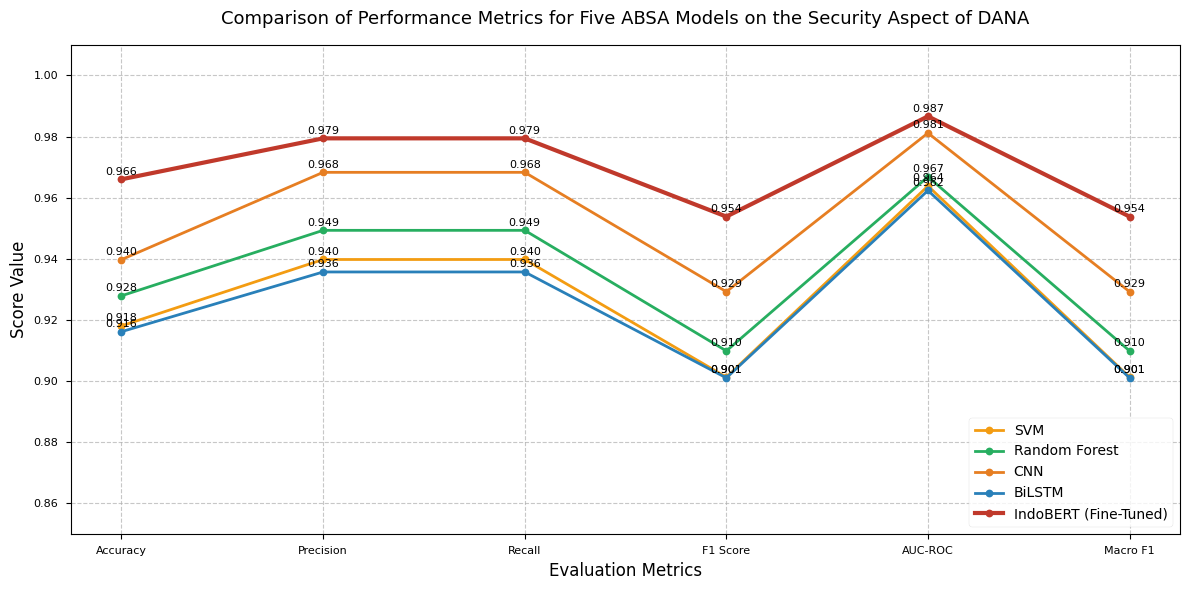

In [ ]:
# ===============================================================
# VISUALISASI GRAFIK PERBANDINGAN
# ===============================================================
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Macro F1']
plt.style.use('seaborn-v0_8-paper')
plt.figure(figsize=(12, 6))

# Plot tiap model dengan warna konsisten
plt.plot(metrics, svm_scores, marker='o', color='#f39c12', linewidth=2, label='SVM')
plt.plot(metrics, rf_scores, marker='o', color='#27ae60', linewidth=2, label='Random Forest')
plt.plot(metrics, cnn_scores, marker='o', color='#e67e22', linewidth=2, label='CNN')
plt.plot(metrics, bilstm_scores, marker='o', color='#2980b9', linewidth=2, label='BiLSTM')
plt.plot(metrics, indobert_scores, marker='o', color='#c0392b', linewidth=3, label='IndoBERT (Fine-Tuned)')

# ===============================================================
# PENGATURAN ESTETIKA
# ===============================================================
plt.title("Comparison of Performance Metrics for Five ABSA Models on the Security Aspect of DANA",
          fontsize=13, pad=15)
plt.xlabel("Evaluation Metrics", fontsize=12)
plt.ylabel("Score Value", fontsize=12)
plt.ylim(0.85, 1.01)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()

# Tambahkan label nilai di atas titik
for i, model_scores in enumerate([svm_scores, rf_scores, cnn_scores, bilstm_scores, indobert_scores]):
    for j, val in enumerate(model_scores):
        plt.text(j, val + 0.0015, f"{val:.3f}", ha='center', fontsize=8)

plt.show()

Robustnes Test

In [ ]:
# ===============================================================
# Import dan Persiapan Data
# ===============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset baru
df_robust = pd.read_csv("robust_dataset.csv")

print("Jumlah data robust:", len(df_robust))
print(df_robust["sentimen"].value_counts())
df_robust.head()

Jumlah data robust: 3000
sentimen
negatif    2050
positif     950
Name: count, dtype: int64


,reviewId,content,clean_content,at,score,sentimen
0,a906f67e-dd05-4843-84e5-58f5e38b03a7,bagus,bagus,2025-10-25 07:27:01,5,positif
1,e17dfb9a-acf5-4f5b-8799-01228cefc409,"aplikasi taik, saya tidak melakukan transaksi,...",aplikasi taik saya tidak melakukan transaksi k...,2025-10-25 07:23:32,1,negatif
2,8ee01d01-51bb-4362-9e8b-721473d254b6,bagus,bagus,2025-10-25 07:22:36,5,positif
3,eea037e2-0985-4116-9c81-91e771183ae4,smkn kesini semakin naik z .....lamax g w paka...,smkn kesini semakin naik z lamax g w pakai lg,2025-10-25 07:22:09,1,negatif
4,d80596b6-b398-4016-912e-020b98dc0078,saya ingin bukti transaksi nya muncul di akun ...,saya ingin bukti transaksi nya muncul di akun ...,2025-10-25 07:20:41,1,negatif


In [ ]:
# Bersihkan teks
df_robust["clean_content"] = df_robust["clean_content"].astype(str).str.lower()

# Konversi label ke numerik
label_map = {"negatif": 0, "positif": 1}
df_robust["label"] = df_robust["sentimen"].map(label_map)

SVM

In [ ]:
# Load pipeline SVM (TF-IDF + classifier)
svm_pipeline = joblib.load("/content/saved_models/svm_pipeline_full.joblib")

# ===============================================================
# Evaluasi model pada data robust
# ===============================================================
y_true = df_robust["label"]
y_pred = svm_pipeline.predict(df_robust["clean_content"])

# Evaluasi
acc_svm = accuracy_score(y_true, y_pred)
f1_svm = f1_score(y_true, y_pred, average='macro')

print("=== 🧩 SVM Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_svm:.4f} | F1-macro={f1_svm:.4f}")

=== 🧩 SVM Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.94      0.86      0.90      2050
     Positif       0.74      0.88      0.81       950

    accuracy                           0.87      3000
   macro avg       0.84      0.87      0.85      3000
weighted avg       0.88      0.87      0.87      3000

Accuracy=0.8657 | F1-macro=0.8516


In [ ]:
# Simpan hasil prediksi
df_robust["predicted_sentiment_svm"] = ["positif" if p == 1 else "negatif" for p in y_pred]
df_robust.to_csv("robust_predictions_svm.csv", index=False)
print("\n✅ Hasil robust test disimpan sebagai robust_predictions_svm.csv")


✅ Hasil robust test disimpan sebagai robust_predictions_svm.csv


Random Forest

In [ ]:
#===============================================================
# 2️⃣ Load pipeline Random Forest (sudah termasuk TF-IDF)
# ===============================================================
rf_pipeline = joblib.load("/content/saved_models/rf_pipeline_full.joblib")

# ===============================================================
# 3️⃣ Prediksi pada dataset robust
# ===============================================================
y_true = df_robust["label"]
y_pred = rf_pipeline.predict(df_robust["clean_content"])

# ===============================================================
# 4️⃣ Evaluasi performa
# ===============================================================
acc_rf = accuracy_score(y_true, y_pred)
f1_rf = f1_score(y_true, y_pred, average='macro')

print("=== 🌲 Random Forest Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_rf:.4f} | F1-macro={f1_rf:.4f}")


=== 🌲 Random Forest Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.93      0.85      0.89      2050
     Positif       0.73      0.87      0.79       950

    accuracy                           0.86      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.87      0.86      0.86      3000

Accuracy=0.8570 | F1-macro=0.8421


In [ ]:
# Simpan hasil prediksi
df_robust["predicted_sentiment_rf"] = ["positif" if p == 1 else "negatif" for p in y_pred]
df_robust.to_csv("robust_predictions_rf.csv", index=False)
print("\n✅ Hasil robust test disimpan sebagai robust_predictions_rf.csv")


✅ Hasil robust test disimpan sebagai robust_predictions_rf.csv


Robust CNN

In [ ]:
# ===============================================================
# Import Library
# ===============================================================
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, precision_recall_curve, auc

In [ ]:
# Load Dataset
df_robust = pd.read_csv("/content/robust_dataset.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Load tokenizer & model
cnn_tokenizer = joblib.load("/content/saved_models/cnn_tokenizer.pkl")
cnn_model = load_model("/content/saved_models/cnn_model_full.h5")

In [ ]:
# Gunakan kolom 'sentimen' sebagai label
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen']

In [ ]:
# ===============================================================
# Tokenisasi dan Padding
# ===============================================================
MAX_SEQUENCE_LEN = 100
X_seq = cnn_tokenizer.texts_to_sequences(df_robust["clean_content"])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

In [ ]:
# ===============================================================
# Prediksi
# ===============================================================
y_prob = cnn_model.predict(X_pad, batch_size=64).ravel()
y_pred = (y_prob >= 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
# Evaluasi
acc_cnn = accuracy_score(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
roc_cnn = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_cnn = auc(recall, precision)

In [ ]:
# Tampilkan hasil
print("=== 🧩 CNN Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_cnn:.4f} | F1-macro={f1_cnn:.4f} | ROC-AUC={roc_cnn:.4f} | PR-AUC={pr_auc_cnn:.4f}")

=== 🧩 CNN Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.93      0.85      0.89      2050
     Positif       0.73      0.87      0.79       950

    accuracy                           0.86      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.87      0.86      0.86      3000

Accuracy=0.8577 | F1-macro=0.8428 | ROC-AUC=0.9180 | PR-AUC=0.8117


BiLSTM

In [ ]:
# ===============================================================
# BiLSTM Robust Evaluation
# ===============================================================
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, precision_recall_curve, auc

In [ ]:
# Load dataset robust
df_robust = pd.read_csv("/content/robust_dataset.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Gunakan kolom 'sentimen' sebagai label
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen']

In [ ]:
# Load BiLSTM model dan tokenizer
bilstm_model = load_model("/content/backup_results/bilstm_model_full.h5")
bilstm_tokenizer = joblib.load("/content/saved_models/tokenizer_bilstm.pkl")

In [ ]:
# Tokenisasi dan padding
MAX_SEQUENCE_LEN = 100
X_seq = bilstm_tokenizer.texts_to_sequences(df_robust["clean_content"])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post')

In [ ]:
# Prediksi
y_prob = bilstm_model.predict(X_pad, batch_size=64).ravel()
y_pred = (y_prob >= 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
# Evaluasi
acc_bilstm = accuracy_score(y_true, y_pred)
f1_bilstm = f1_score(y_true, y_pred, average='macro')
roc_bilstm = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_bilstm = auc(recall, precision)

In [ ]:
# Hasil
print("=== 🌀 BiLSTM Robust Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_bilstm:.4f} | F1-macro={f1_bilstm:.4f} | ROC-AUC={roc_bilstm:.4f} | PR-AUC={pr_auc_bilstm:.4f}")

=== 🌀 BiLSTM Robust Evaluation ===
              precision    recall  f1-score   support

     Negatif       0.94      0.85      0.89      2050
     Positif       0.73      0.87      0.80       950

    accuracy                           0.86      3000
   macro avg       0.83      0.86      0.85      3000
weighted avg       0.87      0.86      0.86      3000

Accuracy=0.8597 | F1-macro=0.8451 | ROC-AUC=0.9014 | PR-AUC=0.7296


IndoBERT

In [ ]:
# ===============================================================
# Robust Evaluation IndoBERT Fine-tuned Model
# ===============================================================
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from tqdm import tqdm

In [ ]:
# Load dataset robust
df_robust = pd.read_csv("/content/robust_dataset.csv")
df_robust['clean_content'] = df_robust['clean_content'].astype(str).fillna('')
df_robust = df_robust[df_robust['clean_content'].str.strip() != ''].reset_index(drop=True)

In [ ]:
# Label encoding dari kolom 'sentimen'
df_robust['sentimen'] = df_robust['sentimen'].map({'negatif': 0, 'positif': 1})
y_true = df_robust['sentimen'].values

In [ ]:
# Load IndoBERT model & tokenizer
model_path = "/content/saved_models/indobert_finetuned"  # ganti jika berbeda
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"🚀 Running on device: {device}")

🚀 Running on device: cuda


In [ ]:
# ===============================================================
# Tokenisasi batch
# ===============================================================
batch_size = 16
encodings = tokenizer(
    df_robust["clean_content"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]

In [ ]:
# ===============================================================
# Inference bertahap (no OOM, binary sigmoid)
# ===============================================================
probs_list = []

with torch.no_grad():
    for i in tqdm(range(0, len(input_ids), batch_size), desc="🔍 Evaluating IndoBERT"):
        batch_input = input_ids[i:i+batch_size].to(device)
        batch_mask = attention_mask[i:i+batch_size].to(device)

        outputs = model(batch_input, attention_mask=batch_mask)
        # Model binary: logits hanya 1 kolom → gunakan sigmoid
        probs = torch.sigmoid(outputs.logits).squeeze()
        probs_list.extend(probs.cpu().numpy())

🔍 Evaluating IndoBERT: 100%|██████████| 188/188 [00:15<00:00, 12.05it/s]


In [ ]:
# ===============================================================
# Evaluasi
# ===============================================================
acc_bert = accuracy_score(y_true, y_pred)
f1_bert = f1_score(y_true, y_pred, average='macro')
roc_bert = roc_auc_score(y_true, y_prob)
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc_bert = auc(recall, precision)


In [ ]:
# ===============================================================
# Hasil akhir
# ===============================================================
print("\n=== 🤖 IndoBERT Robust Evaluation (GPU Binary) ===")
print(classification_report(y_true, y_pred, target_names=["Negatif", "Positif"]))
print(f"Accuracy={acc_bert:.4f} | F1-macro={f1_bert:.4f} | ROC-AUC={roc_bert:.4f} | PR-AUC={pr_auc_bert:.4f}")


=== 🤖 IndoBERT Robust Evaluation (GPU Binary) ===
              precision    recall  f1-score   support

     Negatif       0.94      0.85      0.89      2050
     Positif       0.73      0.87      0.80       950

    accuracy                           0.86      3000
   macro avg       0.83      0.86      0.85      3000
weighted avg       0.87      0.86      0.86      3000

Accuracy=0.8597 | F1-macro=0.8451 | ROC-AUC=0.9014 | PR-AUC=0.7296


extraction

In [ ]:
!pip install xmlschema

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.5/245.5 kB 27.2 MB/s eta 0:00:00


In [ ]:
# ===============================================================
# KNOWLEDGE EXTRACTION (KE) — FINAL VERSION (LOCAL DIRECTORY)
# ===============================================================
# Proses: Load Model Fine-tuned → Load Dataset → Inference → Opinion Extraction → XML Output
# ===============================================================

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import sigmoid
import xml.etree.ElementTree as ET
import re
from collections import Counter
import xmlschema

In [ ]:
# ============================================
# LOAD MODEL INDOBERT FINE-TUNED
# ============================================
model_dir = "/content/saved_models/indobert_model_full"

print("🔄 Memuat model IndoBERT hasil fine-tuning dari direktori lokal...")
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("✅ Model IndoBERT berhasil dimuat!\n")

🔄 Memuat model IndoBERT hasil fine-tuning dari direktori lokal...
✅ Model IndoBERT berhasil dimuat!



In [ ]:
# ============================================
# LOAD DATASET GABUNGAN & CEK TEKS
# ============================================
df = pd.read_csv("/content/combined_dataset_labeled_binary.csv")
print("📂 Dataset dimuat:", df.shape)
print("Kolom yang tersedia:", df.columns.tolist())

# Pastikan kolom teks terdeteksi
if 'clean_content' in df.columns:
    df.rename(columns={'clean_content': 'text'}, inplace=True)
elif 'review' in df.columns:
    df.rename(columns={'review': 'text'}, inplace=True)

# Konversi teks ke string, hapus kosong
df['text'] = df['text'].astype(str).fillna('')
df = df[df['text'].str.strip() != '']

print(f"✅ Total data valid untuk prediksi: {len(df)}\n")
print(df[['text']].head(3))

📂 Dataset dimuat: (7846, 7)
Kolom yang tersedia: ['reviewId', 'content', 'clean_content', 'at', 'score', 'source', 'sentiment']
✅ Total data valid untuk prediksi: 7846

                                                text
0  min apakah server dana sedang bermasalah karen...
1  sangat kecewa saat akan scan wajah selalu gaga...
2  kenapa sdah scan wajah harus masukkan kembali ...


In [ ]:
# ============================================
# PREDIKSI SENTIMEN DENGAN INDOBERT
# ============================================
preds, probs = [], []

print("🧠 Melakukan prediksi sentimen menggunakan IndoBERT...")

for text in df['text']:
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prob = sigmoid(logits).cpu().numpy()[0][0]
        preds.append(1 if prob >= 0.5 else 0)
        probs.append(float(prob))

df['sentiment'] = ['positive' if p == 1 else 'negative' for p in preds]
df['confidence'] = probs
print("✅ Prediksi IndoBERT selesai!\n")
df[['text', 'sentiment', 'confidence']].head(5)

🧠 Melakukan prediksi sentimen menggunakan IndoBERT...
✅ Prediksi IndoBERT selesai!



,text,sentiment,confidence
0,min apakah server dana sedang bermasalah karen...,negative,0.001622
1,sangat kecewa saat akan scan wajah selalu gaga...,negative,0.002474
2,kenapa sdah scan wajah harus masukkan kembali ...,negative,0.002049
3,sayang nya gak ada fitur menu buat pinjam dana...,negative,0.002941
4,sangat nyaman,positive,0.994401


In [ ]:
# ============================================
#  RULE-BASED EKSTRAKSI OPINI
# ============================================
positive_keywords = [
    'aman', 'bagus', 'terpercaya', 'lancar', 'mudah', 'nyaman', 'puas', 'cepat', 'mantap', 'ok'
]
negative_words = [
    'gagal', 'tidak bisa', 'lambat', 'hilang', 'error', 'dibobol', 'hack', 'terblokir',
    'kecewa', 'masalah', 'buruk', 'jelek', 'login gagal', 'otp tidak', 'tidak aman'
]

def extract_opinion_words(text):
    text = text.lower()
    found = []
    for w in positive_keywords + negative_words:
        if re.search(r"\b" + re.escape(w) + r"\b", text):
            found.append(w)
    return ", ".join(found) if found else "-"

df['aspect'] = "Keamanan Dana"
df['opinion_words'] = df['text'].apply(extract_opinion_words)

print("✅ Ekstraksi kata opini selesai!\n")
df[['text', 'opinion_words', 'sentiment']].head(5)

✅ Ekstraksi kata opini selesai!



,text,opinion_words,sentiment
0,min apakah server dana sedang bermasalah karen...,-,negative
1,sangat kecewa saat akan scan wajah selalu gaga...,"gagal, kecewa",negative
2,kenapa sdah scan wajah harus masukkan kembali ...,hilang,negative
3,sayang nya gak ada fitur menu buat pinjam dana...,-,negative
4,sangat nyaman,nyaman,positive


In [ ]:
# ============================================
# MEMBENTUK STRUKTUR XML BARU
# ============================================
print("🧩 Membentuk struktur XML berdasarkan hasil IndoBERT...\n")

root = ET.Element("KnowledgeBase")

for i, row in df.iterrows():
    review = ET.SubElement(root, "Review", id=str(i + 1))
    text_el = ET.SubElement(review, "Text")
    text_el.text = str(row['text'])

    aspect_el = ET.SubElement(review, "Aspect", name=row['aspect'], sentiment=row['sentiment'])
    opinion_el = ET.SubElement(aspect_el, "OpinionWords")
    opinion_el.text = str(row['opinion_words'])

    conf_el = ET.SubElement(aspect_el, "Confidence")
    conf_el.text = f"{row['confidence']:.4f}"

xml_path = "/content/ABSA_KE_Final/knowledge_extraction_indobert_fixed.xml"
tree = ET.ElementTree(root)
tree.write(xml_path, encoding="utf-8", xml_declaration=True)

print(f"✅ File XML final berhasil disimpan ke {xml_path}\n")

🧩 Membentuk struktur XML berdasarkan hasil IndoBERT...

✅ File XML final berhasil disimpan ke /content/ABSA_KE_Final/knowledge_extraction_indobert_fixed.xml



In [ ]:
import os
import shutil

In [ ]:
# ===============================================================
# Setup folder backup
# ===============================================================
backup_dir = "/content/ABSA_KE_Full_Package"
os.makedirs(backup_dir, exist_ok=True)

print("\n📦 Membuat arsip hasil...")

# ===============================================================
# Salin file atau folder hasil utama (AMAN)
# ===============================================================

# 1️⃣ Folder hasil Knowledge Extraction (jika ada)
if os.path.exists("/content/ABSA_KE_Final"):
    shutil.copytree("/content/ABSA_KE_Final", os.path.join(backup_dir, "ABSA_KE_Final"), dirs_exist_ok=True)
    print("✅ Folder ABSA_KE_Final disalin.")
else:
    print("⚠️ Folder /content/ABSA_KE_Final tidak ditemukan, dilewati.")

# 2️⃣ Folder saved_models (semua model tersimpan)
if os.path.exists("/content/saved_models"):
    shutil.copytree("/content/saved_models", os.path.join(backup_dir, "saved_models"), dirs_exist_ok=True)
    print("✅ Folder saved_models disalin.")
else:
    print("⚠️ Folder /content/saved_models tidak ditemukan, dilewati.")

# 3️⃣ Folder khusus IndoBERT fine-tuned
indobert_dir = "/content/saved_models/indobert_model_full"
if os.path.exists(indobert_dir):
    shutil.copytree(indobert_dir, os.path.join(backup_dir, "indobert_model_full"), dirs_exist_ok=True)
    print("✅ Model IndoBERT disalin.")
else:
    print("⚠️ Folder model IndoBERT tidak ditemukan, dilewati.")

# ===============================================================
# 📚 Kompres hasil menjadi satu ZIP
# ===============================================================
zip_path = "/content/ABSA_KE_Full_Package.zip"
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', backup_dir)

print(f"\n✅ Semua hasil disimpan & dikompres ke: {zip_path}")
print("\n🎉 Proses Knowledge Extraction selesai dan siap untuk dianalisis!")


📦 Membuat arsip hasil...
✅ Folder ABSA_KE_Final disalin.
✅ Folder saved_models disalin.
✅ Model IndoBERT disalin.

✅ Semua hasil disimpan & dikompres ke: /content/ABSA_KE_Full_Package.zip

🎉 Proses Knowledge Extraction selesai dan siap untuk dianalisis!


In [ ]:
# ============================================
# VERIFIKASI HASIL
# ============================================
sent_counts = Counter(df['sentiment'])
print("📊 Distribusi Sentimen Hasil IndoBERT:")
for k, v in sent_counts.items():
    print(f"  {k}: {v}")

📊 Distribusi Sentimen Hasil IndoBERT:
  negative: 5498
  positive: 2348


In [ ]:
# validasi XSD
xsd_content = """<?xml version="1.0" encoding="UTF-8"?>
<xs:schema xmlns:xs="http://www.w3.org/2001/XMLSchema"
           elementFormDefault="qualified">

  <xs:element name="KnowledgeBase">
    <xs:complexType>
      <xs:sequence>
        <xs:element name="Review" maxOccurs="unbounded">
          <xs:complexType>
            <xs:sequence>
              <xs:element name="Text" type="xs:string"/>
              <xs:element name="Aspect">
                <xs:complexType>
                  <xs:sequence>
                    <xs:element name="OpinionWords" type="xs:string"/>
                    <xs:element name="Confidence" type="xs:decimal"/>
                  </xs:sequence>
                  <xs:attribute name="name" type="xs:string" use="required"/>
                  <xs:attribute name="sentiment" type="xs:string" use="required"/>
                </xs:complexType>
              </xs:element>
            </xs:sequence>
            <xs:attribute name="id" type="xs:integer" use="required"/>
          </xs:complexType>
        </xs:element>
      </xs:sequence>
    </xs:complexType>
  </xs:element>

</xs:schema>
"""

# Simpan schema
with open("knowledge_extraction_schema.xsd", "w") as f:
    f.write(xsd_content)

# Validasi file XML
schema = xmlschema.XMLSchema("knowledge_extraction_schema.xsd")
xml_path = "/content/ABSA_KE_Final/knowledge_extraction_indobert_fixed.xml"

if schema.is_valid(xml_path):
    print("✅ XML validated successfully against schema!")
else:
    print("❌ XML validation failed:")
    for error in schema.iter_errors(xml_path):
        print(" -", error.message)

✅ XML validated successfully against schema!


In [ ]:
import datetime

validation_log = "/content/ABSA_KE_Final/xml_validation_log.txt"

with open(validation_log, "w") as f:
    f.write("XML Validation Report\n")
    f.write("=====================\n")
    f.write(f"Date: {datetime.datetime.now()}\n")
    f.write(f"XML file: knowledge_extraction_indobert_fixed.xml\n")
    f.write(f"Schema file: knowledge_extraction_schema.xsd\n\n")

    if schema.is_valid(xml_path):
        f.write("✅ XML validated successfully against schema!\n")
    else:
        f.write("❌ XML validation failed:\n")
        for error in schema.iter_errors(xml_path):
            f.write(f" - {error.message}\n")

print("📜 Log validasi disimpan di:", validation_log)

📜 Log validasi disimpan di: /content/ABSA_KE_Final/xml_validation_log.txt


In [ ]:
df.to_csv("/content/backup_dataset_temp.csv", index=False)